# Calculate BL MSE and precip july

In [2]:
import sys
sys.path.append('/work/mh0731/m300876/package/')
import icons
import intake
import matplotlib.pyplot as plt
import healpy as hp
import xarray as xr
import numpy as np
import easygems.healpix as egh
import seaborn as sns
import cmocean

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
icons.prepare_cpu(memory='100GB')

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,Workers: 1
Total threads: 256,Total memory: 93.13 GiB
Status: running,Using processes: False
Comm: inproc://136.172.120.114/2313784/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 93.13 GiB
Comm: inproc://136.172.120.114/2313784/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-advanced//proxy/45363/status,Memory: 93.13 GiB
Nanny: None,


### Predefined functions

In [4]:
#### componenets of NGMS
g = 9.81
cp = 1005 ## J kg-1 K-1
Lv = 2500.93e3

### Calculate omega 
def calc_evapor(ds):
    epsilon = 0.622 #ratio of molar masses of vapor and dry air (0.622)
    return (ds.hus*ds.pressure)/(epsilon + (1-epsilon)*ds.hus)

def calc_pdry(ds):
    return ds.pressure - calc_evapor(ds)

def calc_density(ds):
    Md = 0.0289652  #molar mass of dry air, 0.0289652 kg/mol
    Mv = 0.018016 # molar mass of water vapor, 0.018016 kg/mol
    R = 8.31446 # universal gas constant, 8.31446 J/(K·mol)
    return (calc_pdry(ds)*Md + calc_evapor(ds)*Mv)/(R*ds.ta)

def calc_omega(ds):
    return -calc_density(ds)*ds.wa*g

### Energy components
def calc_mse(ds):
    cv = 719 ## J kg-1 K-1
    Lf = 334e3
    return cp*ds.ta + Lv*ds.hus + g*ds.zg

###wind
def calc_sfcwind(ds):
    return ((ds.uas**2)+(ds.vas**2))**0.5

##surface fluxes
def net_fluxes(ds):
    return (-ds.hflsd - ds.hfssd)

In [5]:
### Location mask
def tropics(ds):
    return np.abs(ds.lat) <= 30.1

def equator(ds):
    return np.abs(ds.lat) <= 5.1

def equator2(ds):
    return (ds.lat >= 2.1) & (ds.lat <= 12.1)

def wpacific(ds):
    return equator(ds) & (ds.lon>150) & (ds.lon<170)

def epacific(ds):
    return equator2(ds) & (ds.lon>240) & (ds.lon<260)

def ocean(ds):
    return (np.isnan(ds.sftlf))

## Calling data

In [6]:
%%time
### ICON
current_location = "online"
cat = cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]
exp_name = "icon_d3hp003"
experiment = cat[exp_name]
time_slice = slice("2020-07-01", "2020-07-31")
ds_icon = (
    experiment(zoom=8, time="P1D", chunks="auto")
    .to_dask()
    .pipe(egh.attach_coords)
    .sel(time=time_slice)
)

CPU times: user 1.89 s, sys: 697 ms, total: 2.59 s
Wall time: 17.7 s


In [7]:
%%time
### NICAM
exp_name = "nicam_gl11"
experiment = cat[exp_name]
time_slice = slice("2020-07-01", "2020-07-31")
ds_nicam = (
    experiment(zoom=8, time="PT6H", chunks="auto")
    .to_dask()
    .sel(time=time_slice)
)

ds_nicam = ds_nicam.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)

CPU times: user 83.6 ms, sys: 5.8 ms, total: 89.4 ms
Wall time: 1.83 s


In [8]:
%%time
### NICAM
exp_name = "nicam_gl11"
experiment = cat[exp_name]
time_slice = slice("2020-07-01", "2020-07-31")
ds_nicam2 = (
    experiment(zoom=8, time="PT3H", chunks="auto")
    .to_dask()
    .sel(time=time_slice)
)

ds_nicam2 = ds_nicam2.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)

CPU times: user 94.6 ms, sys: 2.21 ms, total: 96.9 ms
Wall time: 1.55 s


In [9]:
%%time
### UM
exp_name = "um_glm_n2560_RAL3p3"
experiment = cat[exp_name]
time_slice = slice("2020-07-01", "2020-07-31")
ds_um = (
    experiment(zoom=8, time="PT3H", chunks="auto")
    .to_dask()
    .sel(time=time_slice)
)

ds_um = ds_um.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)

CPU times: user 126 ms, sys: 10.1 ms, total: 136 ms
Wall time: 940 ms


In [10]:
%%time
### UM
exp_name = "um_glm_n2560_RAL3p3"
experiment = cat[exp_name]
time_slice = slice("2020-07-01", "2020-07-31")
ds_um2 = (
    experiment(zoom=8, time="PT1H", chunks="auto")
    .to_dask()
    .sel(time=time_slice)
)

ds_um2 = ds_um2.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)

CPU times: user 97.2 ms, sys: 4.03 ms, total: 101 ms
Wall time: 583 ms


## Calculate $h$, $P$, $\vec{U}_\mathrm{10m}$, $Q_\mathrm{surf}$

### ICON

In [11]:
%%time
mse_icon = calc_mse(ds_icon.sel(
    pressure=slice(92500,100000))).compute()
p = ds_icon.pr.compute()
sfcwind_icon = calc_sfcwind(ds_icon).compute().resample(time='1d').mean()
qsurf_icon = net_fluxes(ds_icon).compute().resample(time='1d').mean()

CPU times: user 3.98 s, sys: 2.84 s, total: 6.82 s
Wall time: 5 s


### UM

In [12]:
%%time
mse_um = calc_mse(ds_um.sel(
    pressure=slice(925,1000))).compute().resample(time='1d').mean()
p_um = ds_um2.pr.compute().resample(time='1d').mean()
sfcwind_um = calc_sfcwind(ds_um2).compute().resample(time='1d').mean()
qsurf_um = net_fluxes(ds_um2).compute().resample(time='1d').mean()

CPU times: user 1min 15s, sys: 34.5 s, total: 1min 50s
Wall time: 1min 21s


### NICAM

In [13]:
%%time
mse_nicam = calc_mse(ds_nicam.sel(
    lev=slice(1000,925))).compute().resample(time='1d').mean()
p_nicam = ds_nicam2.pr.compute().resample(time='1d').mean()
sfcwind_nicam = calc_sfcwind(ds_nicam2).compute().resample(time='1d').mean()
qsurf_nicam = net_fluxes(ds_nicam2).compute().resample(time='1d').mean()

CPU times: user 1min 12s, sys: 21 s, total: 1min 33s
Wall time: 1min 24s


## bin $Q_\mathrm{surf}$ by near surface wind speed

### Western Pacific

In [15]:
bin_qsurf_wpacific_nicam = qsurf_nicam.where(
    wpacific(ds_nicam).compute() & ocean(ds_icon).compute(),drop=True).groupby_bins(
    sfcwind_nicam.where(wpacific(ds_nicam).compute() & ocean(ds_icon).compute(),drop=True),
    bins=np.arange(0,14,0.5)).mean()

In [16]:
bin_qsurf_wpacific_icon = qsurf_icon.where(
    wpacific(ds_icon).compute() & ocean(ds_icon).compute(),drop=True).groupby_bins(
    sfcwind_icon.where(wpacific(ds_icon).compute() & ocean(ds_icon).compute(),drop=True),
    bins=np.arange(0,14,0.5)).mean()

In [17]:
bin_qsurf_wpacific_um = qsurf_um.where(
    wpacific(ds_um).compute() & ocean(ds_icon).compute(),drop=True).groupby_bins(
    sfcwind_um.where(wpacific(ds_um).compute() & ocean(ds_icon).compute(),drop=True),
    bins=np.arange(0,14,0.5)).mean()

### Eastern Pacific

In [18]:
bin_qsurf_epacific_nicam = qsurf_nicam.where(
    epacific(ds_nicam).compute() & ocean(ds_icon).compute(),drop=True).groupby_bins(
    sfcwind_nicam.where(epacific(ds_nicam).compute() & ocean(ds_icon).compute(),drop=True),
    bins=np.arange(0,14,0.5)).mean()

In [19]:
bin_qsurf_epacific_icon = qsurf_icon.where(
    epacific(ds_icon).compute() & ocean(ds_icon).compute(),drop=True).groupby_bins(
    sfcwind_icon.where(epacific(ds_icon).compute() & ocean(ds_icon).compute(),drop=True),
    bins=np.arange(0,14,0.5)).mean()

In [20]:
bin_qsurf_epacific_um = qsurf_um.where(
    epacific(ds_um).compute() & ocean(ds_icon).compute(),drop=True).groupby_bins(
    sfcwind_um.where(epacific(ds_um).compute() & ocean(ds_icon).compute(),drop=True),
    bins=np.arange(0,14,0.5)).mean()

## Plotting

### $Q_\mathrm{surf}$ and near surface wind speed ($\vec{U}_\mathrm{10m}$)

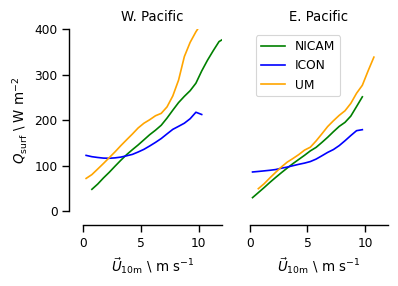

In [19]:
sns.set_context("paper")
fig = plt.figure(figsize=(10/2.54,6/2.54), facecolor="white")
ax = fig.add_subplot(121)

bin_qsurf_wpacific_nicam.plot(color='g',label='NICAM')
bin_qsurf_wpacific_icon.plot(color='b',linestyle='-',label='ICON')
bin_qsurf_wpacific_um.plot(color='orange',label='UM')
ax.set_ylim([0,400])
ax.set_xlim([0,12])
sns.despine(offset=10)
ax.set_xlabel(r'$\vec{U}_\mathrm{10m}$ \ m s$^{-1}$')
ax.set_ylabel(r'$Q_\mathrm{surf}$ \ W m$^{-2}$')
ax.set_title('W. Pacific')

ax = fig.add_subplot(122)

bin_qsurf_epacific_nicam.plot(color='g',label='NICAM')
bin_qsurf_epacific_icon.plot(color='b',linestyle='-',label='ICON')
bin_qsurf_epacific_um.plot(color='orange',label='UM')
ax.set_ylim([0,400])
ax.set_xlim([0,12])
sns.despine(offset=10)
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.set_xlabel(r'$\vec{U}_\mathrm{10m}$ \ m s$^{-1}$')
ax.set_title('E. Pacific')
plt.legend()

### $P$ and boundary layer moist static energy ($h_\mathrm{bl}$)

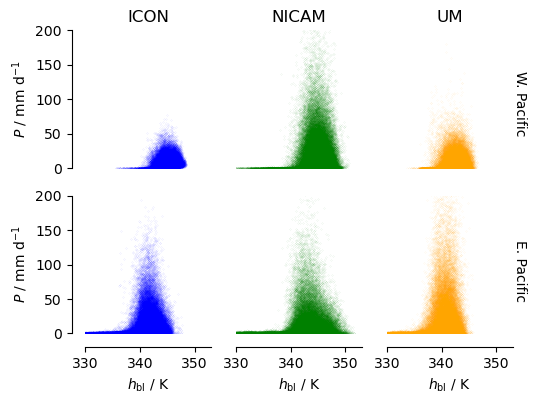

In [24]:
fig1 = plt.figure(figsize=(14/2.54,10/2.54), facecolor="white")
ax1 = fig1.add_subplot(231)
plt.scatter((mse_icon.mean('pressure')/cp).where(wpacific(ds_icon).compute() & ocean(ds_icon).compute(),drop=True),
            p.where(wpacific(ds_icon).compute() & ocean(ds_icon).compute(),drop=True)*24*3600,
s=0.01, c='b',alpha=0.3)

ax1.set_ylim([0,200])
ax1.set_xlim([330,353])
sns.despine(offset=10)
ax1.set_xticks([])
ax1.set_title('ICON')
ax1.set_ylabel(r'$P$ / mm d$^{-1}$')

ax2 = fig1.add_subplot(232)
plt.scatter((mse_nicam.mean('lev')/cp).where(wpacific(ds_nicam).compute() & ocean(ds_icon).compute(),drop=True),
            p_nicam.where(wpacific(ds_nicam).compute() & ocean(ds_icon).compute(),drop=True)*24*3600,
s=0.01, c='g',alpha=0.3);
ax2.set_xlim([330,353])
ax2.set_ylim([0,200])
sns.despine(offset=10)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('NICAM')

ax3 = fig1.add_subplot(233)
plt.scatter((mse_um.mean('pressure')/cp).where(wpacific(ds_um).compute() & ocean(ds_icon).compute(),drop=True),
            p_um.where(wpacific(ds_um).compute() & ocean(ds_icon).compute(),drop=True)*24*3600,
s=0.01, c='orange',alpha=0.3);
ax3.set_xlim([330,353])
ax3.set_ylim([0,200])
sns.despine(offset=10)
ax3.set_xticks([])
ax3.set_yticks([])
plt.text(353,50,'W. Pacific',rotation=-90)
ax3.set_title('UM')


ax4 = fig1.add_subplot(234)
plt.scatter((mse_icon.mean('pressure')/cp).where(epacific(ds_icon).compute() & ocean(ds_icon).compute(),drop=True),
            p.where(epacific(ds_icon).compute() & ocean(ds_icon).compute(),drop=True)*24*3600,
s=0.01, c='b',alpha=0.3);
ax4.set_ylim([0,200])
ax4.set_xlim([330,353])
sns.despine(offset=10)
ax4.set_ylabel(r'$P$ / mm d$^{-1}$')
ax4.set_xlabel(r'$h_\mathrm{bl}$ / K')

ax5 = fig1.add_subplot(235)
plt.scatter((mse_nicam.mean('lev')/cp).where(epacific(ds_nicam).compute() & ocean(ds_icon).compute(),drop=True),
            p_nicam.where(epacific(ds_nicam).compute() & ocean(ds_icon).compute(),drop=True)*24*3600,
s=0.01, c='g',alpha=0.3);
ax5.set_ylim([0,200])
ax5.set_xlim([330,353])
sns.despine(offset=10)
ax5.set_yticks([])
ax5.set_xlabel(r'$h_\mathrm{bl}$ / K')

ax6 = fig1.add_subplot(236)
plt.scatter((mse_um.mean('pressure')/cp).where(epacific(ds_um).compute() & ocean(ds_icon).compute(),drop=True),
            p_um.where(epacific(ds_um).compute() & ocean(ds_icon).compute(),drop=True)*24*3600,
s=0.01, c='orange',alpha=0.3);
ax6.set_ylim([0,200])
ax6.set_xlim([330,353])
sns.despine(offset=10)
ax6.set_yticks([])
ax6.set_xlabel(r'$h_\mathrm{bl}$ / K')


plt.text(353,50,'E. Pacific',rotation=-90)
ax1.spines['bottom'].set_visible(False)
ax2.spines[['bottom','left']].set_visible(False)
ax3.spines[['bottom','left']].set_visible(False)
ax5.spines[['left']].set_visible(False)
ax6.spines[['left']].set_visible(False)